In [1]:
import joblib

X_train, y_train, X_test, y_test = joblib.load('/kaggle/input/bert-emb/bert_train_test_data.pkl')

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import numpy as np

# Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")        

    def call(self, x):
        # e = tanh(Wx + b)
        e = tf.keras.activations.tanh(tf.matmul(x, self.W) + self.b)
        # a = softmax(e)
        a = tf.keras.activations.softmax(e, axis=1)
        # output = a * x
        output = tf.reduce_sum(a * x, axis=1)
        return output


In [13]:
# Model configuration
max_sequence_length, embedding_dim = 128, 768
num_classes = len(np.unique(y_train))  # Assuming y_train is defined with labels

# Model definition
inputs = Input(shape=(max_sequence_length, embedding_dim))
x = LSTM(128, return_sequences=True)(inputs)  # Set return_sequences=True for attention
x = Dropout(0.2)(x)

# Add the attention layer
x = Attention()(x)

# Add dense layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs, outputs)

# Define cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)
optimizer = Adam(learning_rate=cosine_annealing)

# Compile model with the custom learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

# Model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 128)       │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,516 (1.79 MB)

 Trainable params: 470,516 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Check GPU availability
print("Is GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Is GPU available: True
Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.1819 - loss: 2.6197 - val_accuracy: 0.5231 - val_loss: 1.5407
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4690 - loss: 1.6262 - val_accuracy: 0.5798 - val_loss: 1.2982
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5553 - loss: 1.3576 - val_accuracy: 0.5955 - val_loss: 1.2634
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5909 - loss: 1.2812 - val_accuracy: 0.6252 - val_loss: 1.1670
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6476 - loss: 1.1051 - val_accuracy: 0.6446 - val_loss: 1.1196
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6744 - loss: 1.0362 - val_accuracy: 0.6507 - val_loss: 1.1366
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6642 - loss: 1.0550 - val_accuracy: 0.6562 - val_loss: 1.0966
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

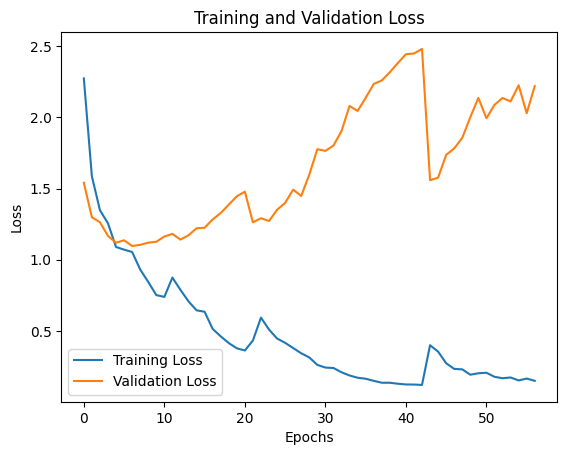

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

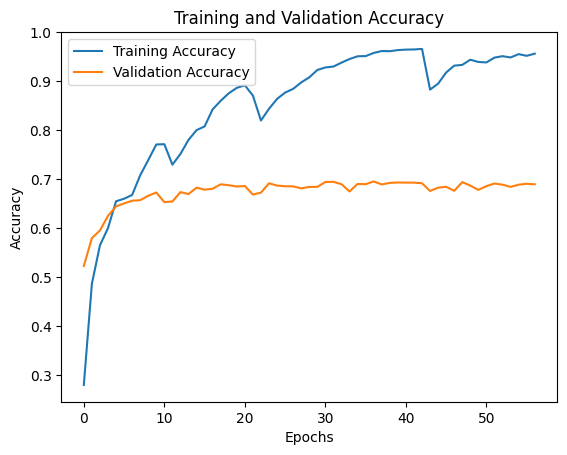

In [17]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6930 - loss: 2.3080
Test Loss: 2.233921527862549
Test Accuracy: 0.6954907178878784


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, LSTM, Input, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import numpy as np

# Model parameters
max_sequence_length, embedding_dim = 128, 768
num_classes = len(np.unique(y_train))  # Assuming y_train is defined with labels

# Define the model
inputs = Input(shape=(max_sequence_length, embedding_dim))
x = LSTM(128, return_sequences=True)(inputs)  # Enable return_sequences=True for multi-head attention
x = Dropout(0.2)(x)

# Add multi-head attention layer
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_output = LayerNormalization()(attention_output + x)  # Residual connection and layer norm

# Apply Global Average Pooling to get a single vector
pooled_output = GlobalAveragePooling1D()(attention_output)

# Pass through dense layers
x = Dense(64, activation='relu')(pooled_output)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)
optimizer = Adam(learning_rate=cosine_annealing)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

# Model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128, 128)  │    459,264 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128)  │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ dropout_6[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 20)        │        660 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 602,484 (2.30 MB)

 Trainable params: 602,484 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Check GPU availability
print("Is GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Is GPU available: True
Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.2272 - loss: 2.5040 - val_accuracy: 0.5780 - val_loss: 1.3640
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5302 - loss: 1.4876 - val_accuracy: 0.6255 - val_loss: 1.1783
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6010 - loss: 1.2573 - val_accuracy: 0.6321 - val_loss: 1.1403
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6200 - loss: 1.2117 - val_accuracy: 0.6631 - val_loss: 1.0783
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6819 - loss: 1.0245 - val_accuracy: 0.6745 - val_loss: 1.0463
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7044 - loss: 0.9548 - val_accuracy: 0.6684 - val_loss: 1.0963
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6891 - loss: 0.9964 - val_accuracy: 0.6676 - val_loss: 1.0985
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - acc

In [8]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

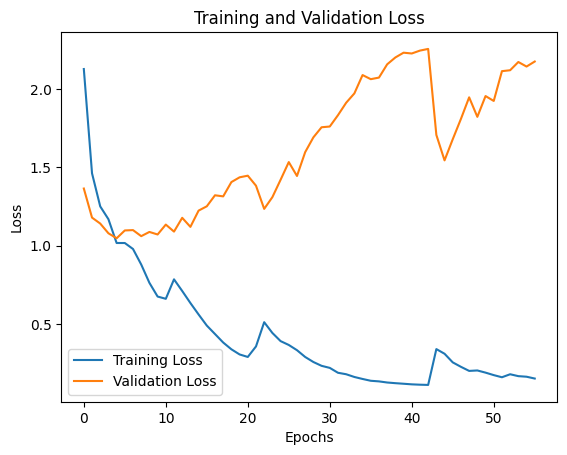

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

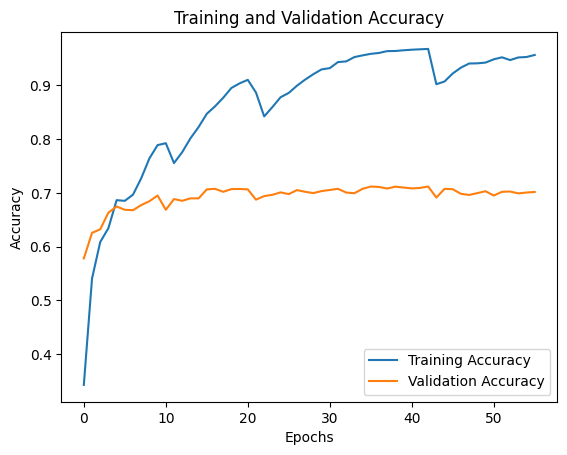

In [10]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7041 - loss: 2.2057
Test Loss: 2.0623905658721924
Test Accuracy: 0.7116711139678955


# Bi-directional

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, Bidirectional, LSTM, Input, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import numpy as np

# Model parameters
max_sequence_length, embedding_dim = 128, 768
num_classes = len(np.unique(y_train))  # Assuming y_train is defined with labels

# Define the model
inputs = Input(shape=(max_sequence_length, embedding_dim))
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)  # Wrap LSTM in Bidirectional
x = Dropout(0.2)(x)

# Add multi-head attention layer
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_output = LayerNormalization()(attention_output + x)  # Residual connection and layer norm

# Apply Global Average Pooling to get a single vector
pooled_output = GlobalAveragePooling1D()(attention_output)

# Pass through dense layers
x = Dense(64, activation='relu')(pooled_output)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)
optimizer = Adam(learning_rate=cosine_annealing)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

# Model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    918,528 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 256)  │          0 │ bidirectional[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 256)  │    263,168 │ dropout_10[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 256)  │        512 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     16,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 20)        │        660 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,201,396 (4.58 MB)

 Trainable params: 1,201,396 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Check GPU availability
print("Is GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Is GPU available: True
Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.1833 - loss: 2.6232 - val_accuracy: 0.5671 - val_loss: 1.3860
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5144 - loss: 1.5171 - val_accuracy: 0.6255 - val_loss: 1.1766
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.6180 - loss: 1.2290 - val_accuracy: 0.6255 - val_loss: 1.1901
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.6304 - loss: 1.1736 - val_accuracy: 0.6653 - val_loss: 1.0746
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.6998 - loss: 0.9724 - val_accuracy: 0.6822 - val_loss: 1.0292
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.7212 - loss: 0.9108 - val_accuracy: 0.6573 - val_loss: 1.0968
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.7062 - loss: 0.9686 - val_accuracy: 0.6865 - val_loss: 1.0589
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - acc

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

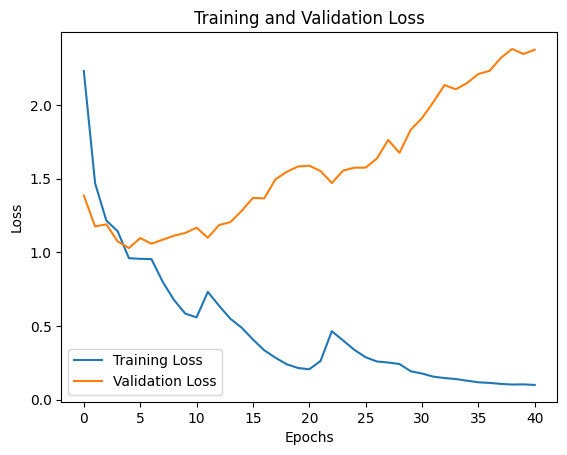

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

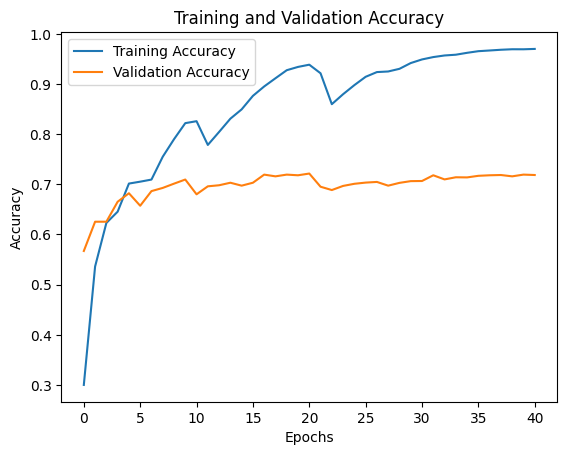

In [16]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7069 - loss: 1.6766
Test Loss: 1.5889679193496704
Test Accuracy: 0.721485435962677


# More regularization

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, Bidirectional, LSTM, Input, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import numpy as np
import json
import gc
import itertools
import os

# Model parameters
max_sequence_length, embedding_dim = 128, 768
num_classes = len(np.unique(y_train))  # Assuming y_train is defined with labels

# Fixed LSTM units
fixed_lstm_units = 256  # LSTM units fixed at 256

# Parameters for grid search (varying only attention_heads and first_decay_steps)
attention_heads_options = [4, 8, 16]
first_decay_steps_options = [10, 20, 40]

# File to store results incrementally in the Kaggle working directory
results_file = "/kaggle/working/model_results.json"

# Check if results file exists and load existing results if present
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        results = json.load(f)
else:
    results = []

# Grid search with memory management for attention heads and decay steps only
for attention_heads, first_decay_steps in itertools.product(attention_heads_options, first_decay_steps_options):

    # Define the model with the fixed LSTM units and current hyperparameters
    inputs = Input(shape=(max_sequence_length, embedding_dim))
    x = Bidirectional(LSTM(fixed_lstm_units, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)

    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=attention_heads, key_dim=64)(x, x)
    attention_output = LayerNormalization()(attention_output + x)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(attention_output)

    # Dense layers
    x = Dense(64, activation='relu')(pooled_output)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Cosine annealing learning rate schedule
    cosine_annealing = CosineDecayRestarts(
        initial_learning_rate=0.0005,
        first_decay_steps=first_decay_steps,
        t_mul=2,
        alpha=0.01
    )
    optimizer = Adam(learning_rate=cosine_annealing)

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,  # Limit epochs to 100 to reduce time and memory usage
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Convert history values to 32-bit floats to save memory
    history_data = {
        'train_loss': [float(np.float32(loss)) for loss in history.history['loss']],
        'train_accuracy': [float(np.float32(acc)) for acc in history.history['accuracy']],
        'val_loss': [float(np.float32(val_loss)) for val_loss in history.history['val_loss']],
        'val_accuracy': [float(np.float32(val_acc)) for val_acc in history.history['val_accuracy']]
    }

    # Store model parameters and performance in a temporary dictionary
    model_result = {
        'lstm_units': fixed_lstm_units,  # Fixed LSTM units
        'attention_heads': attention_heads,
        'first_decay_steps': first_decay_steps,
        'history': history_data
    }

    # Append to results list and immediately save it to the file
    results.append(model_result)
    with open(results_file, 'w') as f:
        json.dump(results, f)

    # Clear the model from memory
    tf.keras.backend.clear_session()
    gc.collect()  # Explicit garbage collection

    # Print the progress to monitor progress during execution
    print(f"Completed training with attention heads={attention_heads}, first decay steps={first_decay_steps}")

# After all configurations have run, results will contain the complete list of experiments.


Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.2039 - loss: 2.5805 - val_accuracy: 0.5764 - val_loss: 1.3865
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.5194 - loss: 1.5252 - val_accuracy: 0.6117 - val_loss: 1.2174
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6093 - loss: 1.2470 - val_accuracy: 0.6358 - val_loss: 1.1606
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6268 - loss: 1.2103 - val_accuracy: 0.6727 - val_loss: 1.0796
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6983 - loss: 0.9858 - val_accuracy: 0.6780 - val_loss: 1.0672
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.7105 - loss: 0.9222 - val_accuracy: 0.6708 - val_loss: 1.1005
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.7003 - loss: 0.9864 - val_accuracy: 0.6748 - val_loss: 1.0937
Epoch 8/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7360 - loss: 0

In [4]:
import json
import matplotlib.pyplot as plt

# Load results from the JSON file
results_file = "/kaggle/working/model_results.json"
with open(results_file, 'r') as f:
    results = json.load(f)

# Find the best model configuration based on the final validation accuracy
best_model = max(results, key=lambda x: max(x['history']['val_accuracy']))
optimal_lstm_units = best_model['lstm_units']
optimal_attention_heads = best_model['attention_heads']
optimal_decay_steps = best_model['first_decay_steps']

# Print the best model's configuration and its maximum validation accuracy
print("Optimal Configuration:")
print(f"LSTM Units: {optimal_lstm_units}")
print(f"Attention Heads: {optimal_attention_heads}")
print(f"First Decay Steps: {optimal_decay_steps}")
print(f"Maximum Validation Accuracy: {max(best_model['history']['val_accuracy'])}")

Optimal Configuration:
LSTM Units: 256
Attention Heads: 16
First Decay Steps: 40
Maximum Validation Accuracy: 0.7267904281616211


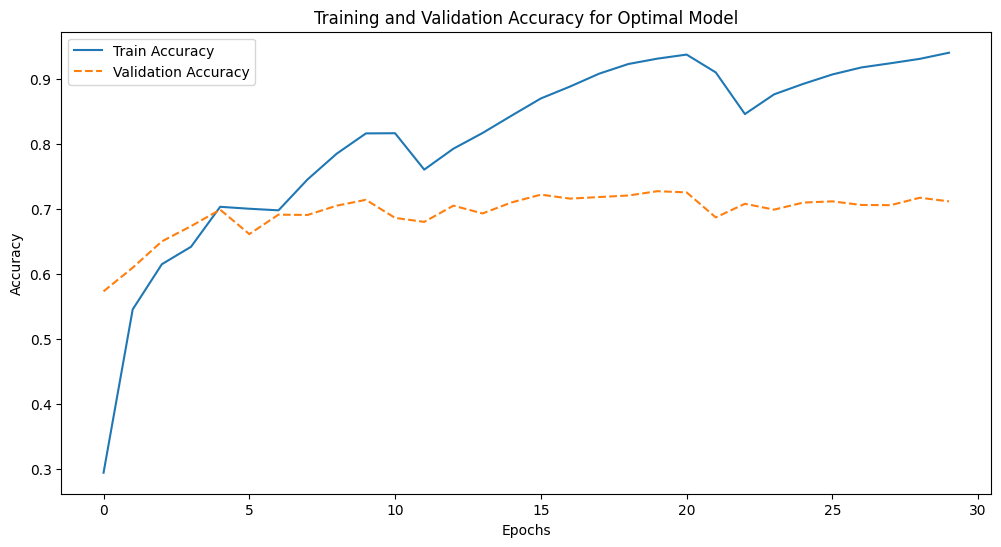

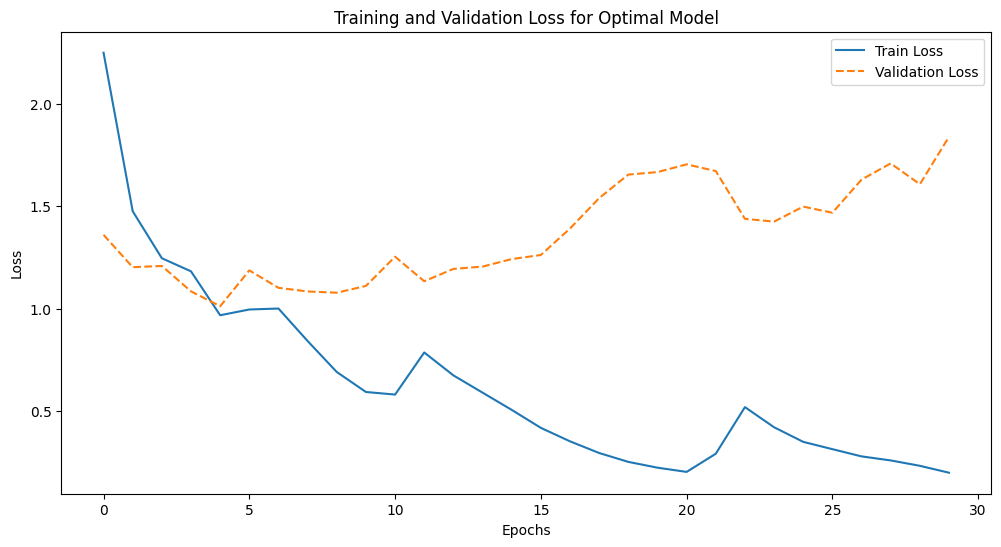

In [5]:

# Optional: Plot train and validation accuracy for the best model
plt.figure(figsize=(12, 6))
plt.plot(best_model['history']['train_accuracy'], label='Train Accuracy')
plt.plot(best_model['history']['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.title('Training and Validation Accuracy for Optimal Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(best_model['history']['train_loss'], label='Train Loss')
plt.plot(best_model['history']['val_loss'], label='Validation Loss', linestyle='dashed')
plt.title('Training and Validation Loss for Optimal Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


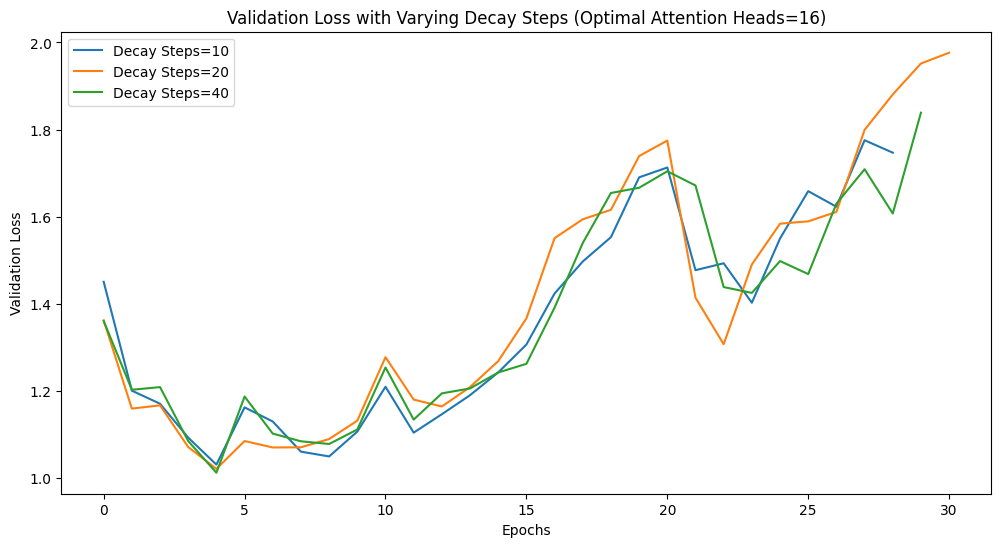

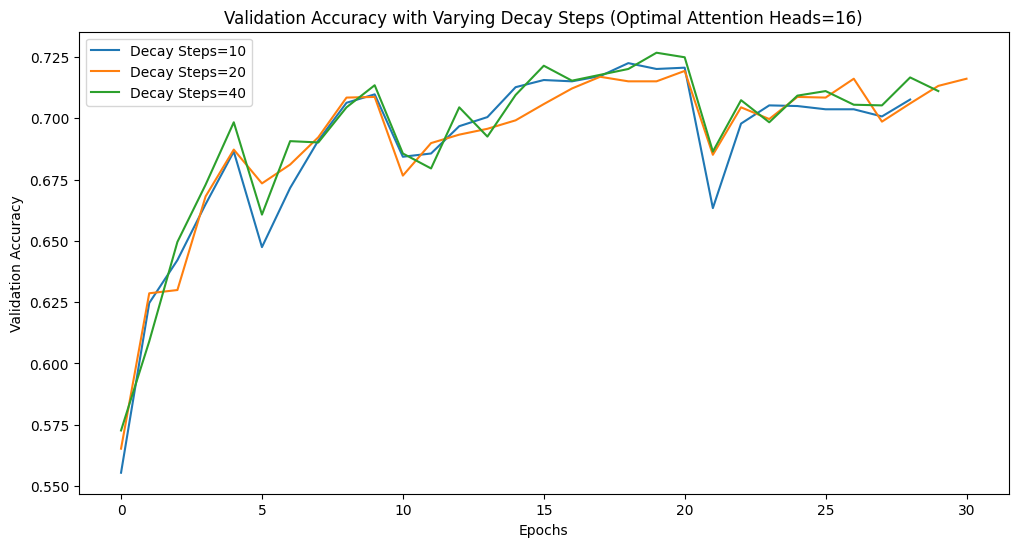

In [7]:
import json
import matplotlib.pyplot as plt

# Load results from the JSON file
results_file = "/kaggle/working/model_results.json"
with open(results_file, 'r') as f:
    results = json.load(f)

# Get the optimal attention_heads value from the previous best model analysis
best_model = max(results, key=lambda x: max(x['history']['val_accuracy']))
optimal_attention_heads = best_model['attention_heads']
optimal_lstm_units = best_model['lstm_units']

# Filter results for configurations with optimal attention_heads and optimal lstm_units
filtered_results = [r for r in results if r['attention_heads'] == optimal_attention_heads and r['lstm_units'] == optimal_lstm_units]

# Plot Validation Loss for each decay_steps on the same graph
plt.figure(figsize=(12, 6))
for result in filtered_results:
    decay_steps = result['first_decay_steps']
    val_loss = result['history']['val_loss']
    plt.plot(val_loss, label=f'Decay Steps={decay_steps}')
plt.title(f'Validation Loss with Varying Decay Steps (Optimal Attention Heads={optimal_attention_heads})')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Plot Validation Accuracy for each decay_steps on the same graph
plt.figure(figsize=(12, 6))
for result in filtered_results:
    decay_steps = result['first_decay_steps']
    val_accuracy = result['history']['val_accuracy']
    plt.plot(val_accuracy, label=f'Decay Steps={decay_steps}')
plt.title(f'Validation Accuracy with Varying Decay Steps (Optimal Attention Heads={optimal_attention_heads})')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


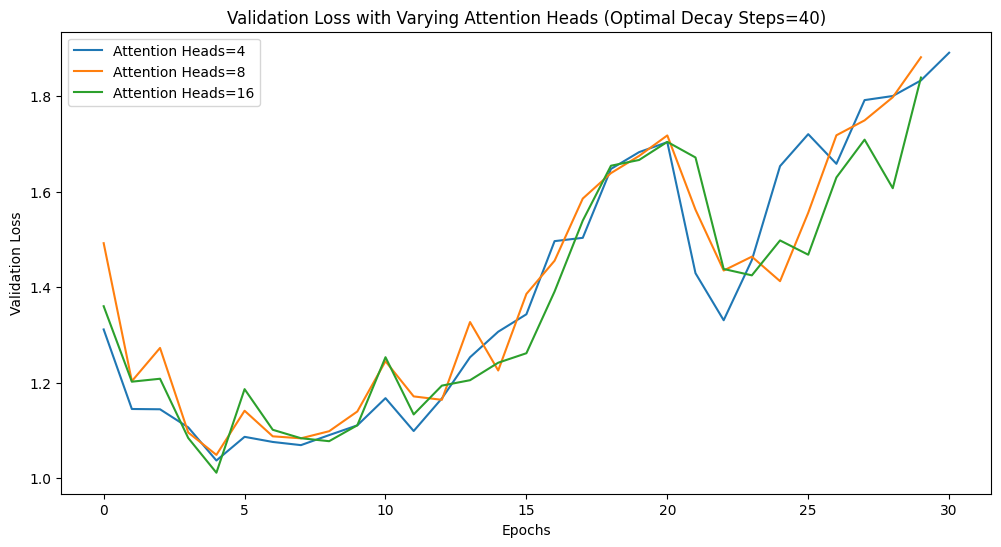

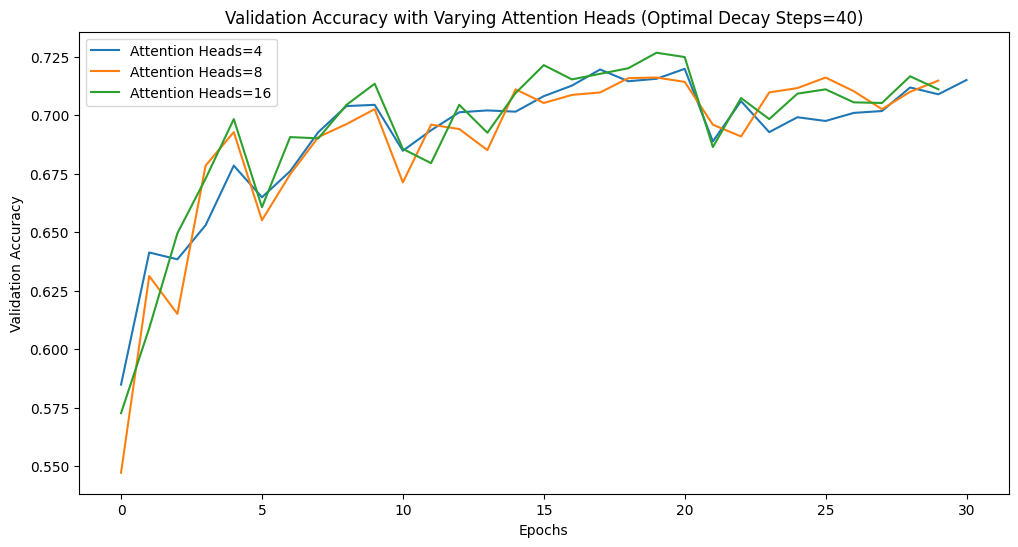

In [8]:
import json
import matplotlib.pyplot as plt

# Load results from the JSON file
results_file = "/kaggle/working/model_results.json"
with open(results_file, 'r') as f:
    results = json.load(f)

# Get the optimal first_decay_steps value from the previous best model analysis
best_model = max(results, key=lambda x: max(x['history']['val_accuracy']))
optimal_decay_steps = best_model['first_decay_steps']
optimal_lstm_units = best_model['lstm_units']

# Filter results for configurations with optimal first_decay_steps and optimal lstm_units
filtered_results = [r for r in results if r['first_decay_steps'] == optimal_decay_steps and r['lstm_units'] == optimal_lstm_units]

# Plot Validation Loss for each attention_heads on the same graph
plt.figure(figsize=(12, 6))
for result in filtered_results:
    attention_heads = result['attention_heads']
    val_loss = result['history']['val_loss']
    plt.plot(val_loss, label=f'Attention Heads={attention_heads}')
plt.title(f'Validation Loss with Varying Attention Heads (Optimal Decay Steps={optimal_decay_steps})')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Plot Validation Accuracy for each attention_heads on the same graph
plt.figure(figsize=(12, 6))
for result in filtered_results:
    attention_heads = result['attention_heads']
    val_accuracy = result['history']['val_accuracy']
    plt.plot(val_accuracy, label=f'Attention Heads={attention_heads}')
plt.title(f'Validation Accuracy with Varying Attention Heads (Optimal Decay Steps={optimal_decay_steps})')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
